In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
import reboundx
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech import Poincare
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

In [2]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

def eq_mass_120(seed, P12, etilde, mu):
    np.random.seed(seed)
    ec = 1 - P12**(2/3)
    e = etilde*ec

    # Need to give each planet e/sqrt(3) in order for e12 to equal e with pericentrs 120 degrees apart
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1, 'e':e/np.sqrt(3), 'pomega':0, 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'e':e/np.sqrt(3), 'pomega':2*np.pi/3, 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12**2, 'e':e/np.sqrt(3), 'pomega':4*np.pi/3, 'M':np.random.random()*2*np.pi}, sim=sim)
    sim.move_to_com()

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_eqmass_120(params): # collision: megno = 10000, lyap = 1/10, megno nan: megno = 1000, lyap = 1/20
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.abs(2 * np.pi / eigvals)
        tmax = 3*Tsec[1] # take 3 x the middle eigenvalue, rather than the longest which is much longer, corresponding to ecom
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

def calc_tau_max(params): 
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    return tau_max(sim)

def calc_tau_max_nosec(params): 
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    return tau_max(sim, sec=False)

def calc_P17_reg(params): 
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    return regular_petit17(sim, sec=True)

def calc_P17_reg_nosec(params): 
    seed, P12, etilde, mu, tmax = params
    sim = eq_mass_120(seed, P12, etilde, mu)
    return regular_petit17(sim, sec=False)

In [3]:
def get_pool_params(xlist, ylist, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, y, mu, tmax))
            ctr += 1
    return params
             
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False
        
def LLsoln(M, Gx0, Gy0, times):
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    freqs = np.diag(np.diag(vals))
    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    print(Ax0)
    print(Ay0)
    
    cos_vals = np.array([np.cos(freq * times) for freq in freqs]).T
    sin_vals = np.array([np.sin( freq * times) for freq in freqs]).T
    Ax = Ax0 * cos_vals - Ay0 * sin_vals    
    Ay = Ax0 * sin_vals + Ay0 * cos_vals
    Gx = np.transpose(T @ Ax.T).T
    Gy = np.transpose(T @ Ay.T).T
    
    return Gx, Gy

def LLeminus(sim, times, i1, i2):
    secres = sec(sim, i1, i2)
    Gx, Gy = LLsoln(secres['M'], secres['Gammax'], secres['Gammay'], times)
    Fx = secres['R'] @ Gx/secres['Lr']**(1/2)
    Fy = secres['R'] @ Gy/secres['Lr']**(1/2)
    eminus = np.sqrt(Fx[i1-1]**2 + Fy[i1-1]**2) # eminus is always in the i1 slot
    return eminus

In [4]:
def etilde_max(sim, lsys, Lambda, i1, i2, sec=True):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    ps = sim.particles
    ecross = (1-(ps[i1].P/ps[i2].P)**(2/3))
    
    if sec == False:
        emx = ps[i2].e*np.cos(ps[i2].pomega) - ps[i1].e*np.cos(ps[i1].pomega)
        emy = ps[i2].e*np.sin(ps[i2].pomega) - ps[i1].e*np.sin(ps[i1].pomega)
        emax = np.sqrt(emx**2 + emy**2)
    else:
        res = {}
        res['L10'] = Lambda[i1-1]
        res['L20'] = Lambda[i2-1]
        res['L12'] = res['L10'] + res['L20']
        res['Lr'] = res['L10']*res['L20']/res['L12']
        res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
        res['R'] = np.identity(Lambda.shape[0]) # Nplanets x Nplanets rotation matrix
        # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
        res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])

        Mnorm = res['R'] @ lsys.Neccentricity_matrix @ res['R'].T
        Fx0 = res['R'] @ lsys.kappa0_vec/res['Lr']**(1/2)
        Fy0 = res['R'] @ lsys.eta0_vec/res['Lr']**(1/2)

        vals,T = np.linalg.eigh(Mnorm)

        Ax0 = T.T @ Fx0
        Ay0 = T.T @ Fy0
        A = np.sqrt(Ax0**2 + Ay0**2) # Mode amplitudes (A[0], A[1])
        Fmax = np.abs(T) @ A.T
        emax = Fmax[i1-1] # i1-1 index is eminus for the i1,i2 pair
    return emax/ecross

def calc_tau(sim, lsys, Lambda, i1, i2, sec=True):
    etildemax = etilde_max(sim, lsys, Lambda, i1, i2, sec=sec)
    ps = sim.particles
    delta = (ps[i2].a-ps[i1].a)/ps[i2].a/(ps[i1].m+ps[i2].m)**(1/4)
    tau = 1.15/delta**2/np.abs(np.log(etildemax**(1/2)))**(3/2)
    return tau

def tau_max(sim, sec=True):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    pvars = Poincare.from_Simulation(sim)
    Lambda = np.array([p.Lambda for p in pvars.particles[1:]])
    
    tau_max = 0
    for i in range(1, sim.N_real):
        tau = 0
        if i-1 >= 1:
            tau += calc_tau(sim, lsys, Lambda, i-1, i, sec=sec)
        if i+1 < sim.N_real:
            tau += calc_tau(sim, lsys, Lambda, i, i+1, sec=sec)
        if tau > tau_max:
            tau_max = tau
        #print(i, tau)
    return tau_max

def regular_petit17(sim, sec=True):
    '''
    calculates etilde / etildecrit for 1st order MMR overlap from Petit & Laskar 17, under the regular LL evolution.
    If the collisional criterion (etilde=1) is more stringent (Laskar & Petit 17) returns etildemax under LL evolution
    '''
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    pvars = Poincare.from_Simulation(sim)
    Lambda = np.array([p.Lambda for p in pvars.particles[1:]])
    
    eratiomax = 0
    ps = sim.particles
    for i in range(1, sim.N_real-1):
        alpha = ps[i].a/ps[i+1].a
        eps = (ps[i].m + ps[i+1].m)/ps[0].m
        # max etilde from regular LL evolution
        etildemax = etilde_max(sim, lsys, Lambda, i, i+1, sec=sec)
        # calculate ratio of etildemax from regular LL evolution to critical etilde for MMR overlap
        P17MMReratio = P17_reg_eratio_MMR(etildemax, alpha, eps)
        # If this ratio is less than 1, but etildemax > 1 (orbit crossing, Laskar17), take etildemax
        rmax = max(P17MMReratio, etildemax)
        # take max over all pairs
        if rmax > eratiomax:
            eratiomax = rmax
    return eratiomax

def P17_reg_eratio_MMR(etildemax, alpha, eps):
    '''
    calculates etilde / etildecrit for 1st order MMR overlap from Petit & Laskar 17 Eqs 87 & 88
    '''
    r = 0.80199 # Eq 28
    g = (3**4*(1-alpha)**5)/2**9/r/eps - 32*r*eps/9/(1-alpha)**2 # Eq 88
    alphaoverlap = 1 - 1.46*eps**(2/7) # Eq 76
    if alpha > alphaoverlap: # 1st order MMRs overlap at 0 ecc
        if etildemax == 0:
            etildemax = 1e-3
        return 1/etildemax # make it always greater than 1, but increasing with etilde so we can plot contour=1 along e=0
    else:
        etildecrit = g/(1-alpha)
        return etildemax / etildecrit

In [ ]:
mu=1e-4
etildemax=1
tmax = None

Pmin = 1/1.05
Pmax = 1/2
NPs = 96
Nes = 32
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [ ]:
calc_tau_max((0, 1/1.83, 0.3, 1e-4, 0))

In [ ]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(calc_tau_max, params)
np.save('EqSpacing120taus.npy', results)

In [ ]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(calc_tau_max_nosec, params)
np.save('EqSpacing120taus_nosec.npy', results)

In [ ]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(calc_P17_reg, params)
np.save('EqSpacing120P17.npy', results)

In [ ]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(calc_P17_reg_nosec, params)
np.save('EqSpacing120P17_nosec.npy', results)

In [ ]:
%%time
params = get_pool_params(P12s, etildes, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_120, params)
np.save('EqSpacing120.npy', results)

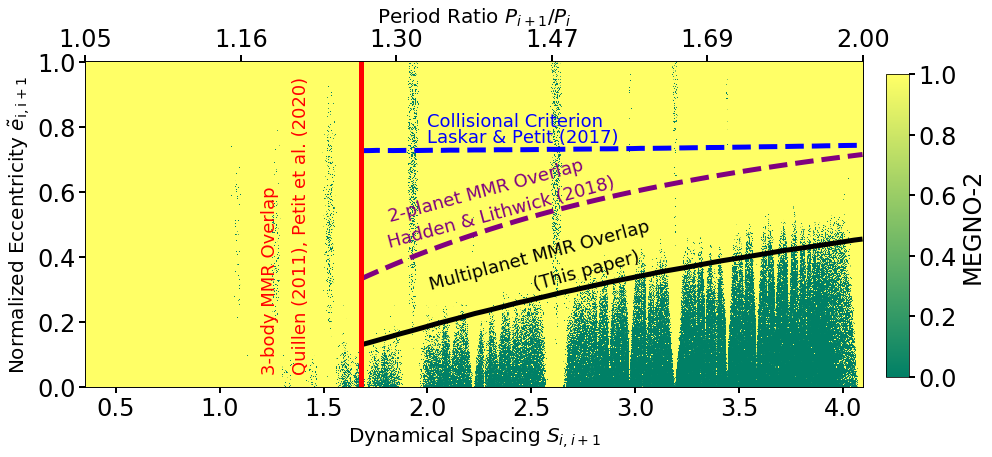

In [6]:
from matplotlib.lines import Line2D
plt.style.use('paper')

fig, ax = plt.subplots(figsize=(16,6))

mu=1e-4
etildemax=1

Pmin = 1/1.05
Pmax = 1/2
NPs = 96
Nes = 32
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

mu = 2*mu/3
deltas = (1-P12s**(2/3))/mu**(1/4)
deltashi = deltas[deltas > 1.68]
deltaslo = deltas[deltas < 1.68]

tau = np.load('EqSpacing120taus.npy')
taugrid = np.array(tau).reshape(Nes,NPs)
taugrid = taugrid[:,len(deltaslo):]
tauX,tauY = np.meshgrid(deltashi, etildes)

p17 = np.load('EqSpacing120P17.npy')
p17grid = np.array(p17).reshape(Nes,NPs)
p17gridhi = p17grid[:,len(deltaslo):]
p17Xhi,p17Yhi = np.meshgrid(deltashi, etildes)
p17gridlo = p17grid[:,:len(deltaslo)]
p17Xlo,p17Ylo = np.meshgrid(deltaslo, etildes)

mu=1e-4
etildemax=1

Pmin = 1/1.05
Pmax = 1/2
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

mu = 2*mu/3
deltas = (1-P12s**(2/3))/mu**(1/4)

megno = np.load('EqSpacing120.npy')
X,Y,Z = get_centered_grid(deltas, etildes, np.array(megno)-2)

im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
ax.set_xlabel(r"$P2/P1$")

ax.plot(deltashi, np.exp(-2.2*deltashi**(-4/3)), color='purple', linestyle='--', lw=5, label='Hadden & Lithwick (2018)')

cs = ax.contour(tauX, tauY, taugrid, levels=[1], colors='k', linewidths=[5])
cs = ax.contour(p17Xhi, p17Yhi, p17gridhi, levels=[1], colors='blue', linestyles=['--'], linewidths=[5])
ax.axvline(1.68, color='red', linewidth=5)

fig.subplots_adjust(right=0.8, wspace=0.05)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r'Dynamical Spacing $S_{i,i+1}$')
ax.set_ylabel(r'Normalized Eccentricity $\tilde{e}_{\rm{i,i+1}}}$')

ax2 = ax.twiny()
ax2.set_xticklabels(["{0:.2f}".format(d) for d in 1/np.linspace(P12s.max(), P12s.min(), 6)], fontsize=24)
ax2.set_xlabel(r"Period Ratio $P_{i+1}/P_{i}$")

ax.text(2, 0.8, 'Collisional Criterion', color='blue', fontsize=18)
ax.text(2, 0.75, 'Laskar & Petit (2017)', color='blue', fontsize=18)

ax.text(2, 0.3, 'Multiplanet MMR Overlap', color='black', rotation=15, fontsize=18)
ax.text(2.5, 0.3, '(This paper)', color='black', rotation=15, fontsize=18)

ax.text(1.8, 0.51, '2-planet MMR Overlap', color='purple', rotation=15, fontsize=18)
ax.text(1.8, 0.43, 'Hadden & Lithwick (2018)', color='purple', rotation=15, fontsize=18)

ax.text(1.2, 0.05, '3-body MMR Overlap', color='red', rotation=90, fontsize=18)
ax.text(1.35, 0.05, 'Quillen (2011), Petit et al. (2020)', color='red', rotation=90, fontsize=18)

fig.savefig('schematicMEGNO.pdf')